In [688]:
import scanpy as sc
import os
import rapids_singlecell as rsc
import cfp
import functools
import os
import sys
import traceback
from typing import Dict, Literal, Optional, Tuple
import cfp
import scanpy as sc
import numpy as np
import functools
from ott.solvers import utils as solver_utils
import optax
from omegaconf import OmegaConf
from typing import NamedTuple, Any
import hydra
import wandb
import anndata as ad
import pandas as pd
import os
from cfp.training import ComputationCallback
from cfp.preprocessing import transfer_labels, compute_wknn
from cfp.training import ComputationCallback
from numpy.typing import ArrayLike
from cfp.metrics import compute_r_squared, compute_e_distance
from scipy.stats import percentileofscore

sc.set_figure_params(dpi_save=400)

In [2]:
dir = "/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/zebrafish/single_condition_f"

In [3]:
[el for el in os.listdir(dir) if "cdx4_cdx1a" in el]

['ruby-tree-53_cdx4_cdx1a_24.csv',
 'hopeful-mountain-62_cdx4_cdx1a_18_pred.h5ad',
 'lucky-voice-7_cdx4_cdx1a_36_pred.h5ad',
 'lucky-voice-7_cdx4_cdx1a_36.csv',
 'ruby-tree-53_cdx4_cdx1a_24_pred.h5ad',
 'hopeful-mountain-62_cdx4_cdx1a_18.csv']

In [4]:
wandb_name = "lucky-voice-7"

In [5]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")

In [6]:
cf = cfp.model.CellFlow.load(os.path.join(dir, f"{wandb_name}_CellFlow.pkl"))

In [6]:
ood_cond = "cdx4_cdx1a_36"
gene_target = "_".join(ood_cond.split("_")[:2])

In [8]:
control_key = "is_control"
adata_ctrl = adata[adata.obs[control_key].to_numpy()]
covariate_data = adata[adata.obs["gene_target"]==gene_target].obs.drop_duplicates(subset=["condition"])
    

In [9]:
covariate_data

cell  Size_Factor   n.umi  \
A03_B01_P01-A02_LIG135  A03_B01_P01-A02_LIG135     3.180959  1445.0   
A03_B01_P01-B03_LIG140  A03_B01_P01-B03_LIG140     0.640595   291.0   
A03_B01_P01-B09_LIG107  A03_B01_P01-B09_LIG107     0.827710   376.0   

                        perc_mitochondrial_umis  timepoint  \
A03_B01_P01-A02_LIG135                16.332180       36.0   
A03_B01_P01-B03_LIG140                 0.000000       24.0   
A03_B01_P01-B09_LIG107                 1.329787       18.0   

                                         Oligo  hash_umis  \
A03_B01_P01-A02_LIG135    36h_cdx4-cdx1a_P2_G7    31949.0   
A03_B01_P01-B03_LIG140  24h_cdx4-cdx1a_P12_G10        9.0   
A03_B01_P01-B09_LIG107   18h_cdx4-cdx1a_P12_C5       14.0   

                        top_to_second_best_ratio  \
A03_B01_P01-A02_LIG135                       inf   
A03_B01_P01-B03_LIG140                  6.017207   
A03_B01_P01-B09_LIG107                  8.034506   

                                                         cell_type_sub  \
A03_B01_P01-A02_LIG135                            mature slow muscle 3   
A03_B01_P01-B03_LIG140                   neural progenitor (hindbrain)   
A03_B01_P01-B09_LIG107  neural progenitor (telencephalon/diencephalon)   

                                                       cell_type_broad  ...  \
A03_B01_P01-A02_LIG135                              mature slow muscle  ...   
A03_B01_P01-B03_LIG140                   neural progenitor (hindbrain)  ...   
A03_B01_P01-B09_LIG107  neural progenitor (telencephalon/diencephalon)  ...   

                       hash_plate log.hash_umis  gene1+gene2  gene_target_1  \
A03_B01_P01-A02_LIG135         P2      4.504457   cdx4+cdx1a           cdx4   
A03_B01_P01-B03_LIG140        P12      0.954243   cdx4+cdx1a           cdx4   
A03_B01_P01-B09_LIG107        P12      1.146128   cdx4+cdx1a           cdx4   

                        gene_target_2      condition  is_control  \
A03_B01_P01-A02_LIG135          cdx1a  cdx4_cdx1a_36       False   
A03_B01_P01-B03_LIG140          cdx1a  cdx4_cdx1a_24       False   
A03_B01_P01-B09_LIG107          cdx1a  cdx4_cdx1a_18       False   

                        first_t_control   logtime     germ_layer_adapted  
A03_B01_P01-A02_LIG135            False  3.583519  mesoderm_neural_crest  
A03_B01_P01-B03_LIG140            False  3.178054  ectoderm_neural_crest  
A03_B01_P01-B09_LIG107            False  2.890372  ectoderm_neural_crest  

[3 rows x 36 columns]

In [10]:
def _build_anndata(preds: dict[str, ArrayLike]) -> ad.AnnData:
    all_data = []
    conditions = []
    
    for condition, array in preds.items():
        all_data.append(array)
        conditions.extend([condition] * array.shape[0])
    
    all_data_array = np.vstack(all_data)
    obs_data = pd.DataFrame({
        'condition': conditions
    })
    adata_pred = ad.AnnData(X=np.empty((len(all_data_array),1)), obs=obs_data)
    adata_pred.obsm["X_aligned"] = all_data_array
    return adata_pred


In [11]:
adata_ctrl_36 = adata_ctrl[adata_ctrl.obs["timepoint"]==36]
covariate_data_36 = covariate_data[covariate_data["timepoint"]==36]

In [12]:
adata_ctrl_36.n_obs

158564

In [13]:
sc.pp.subsample(adata_ctrl_36, n_obs=100_000)

In [14]:
covariate_data_36

cell  Size_Factor   n.umi  \
A03_B01_P01-A02_LIG135  A03_B01_P01-A02_LIG135     3.180959  1445.0   

                        perc_mitochondrial_umis  timepoint  \
A03_B01_P01-A02_LIG135                 16.33218       36.0   

                                       Oligo  hash_umis  \
A03_B01_P01-A02_LIG135  36h_cdx4-cdx1a_P2_G7    31949.0   

                        top_to_second_best_ratio         cell_type_sub  \
A03_B01_P01-A02_LIG135                       inf  mature slow muscle 3   

                           cell_type_broad  ... hash_plate log.hash_umis  \
A03_B01_P01-A02_LIG135  mature slow muscle  ...         P2      4.504457   

                        gene1+gene2  gene_target_1  gene_target_2  \
A03_B01_P01-A02_LIG135   cdx4+cdx1a           cdx4          cdx1a   

                            condition  is_control  first_t_control   logtime  \
A03_B01_P01-A02_LIG135  cdx4_cdx1a_36       False            False  3.583519   

                           germ_layer_adapted  
A03_B01_P01-A02_LIG135  mesoderm_neural_crest  

[1 rows x 36 columns]

In [15]:
adata_ctrl_36.uns = adata.uns.copy()
preds = cf.predict(adata=adata_ctrl_36, sample_rep="X_aligned", condition_id_key="condition", covariate_data=covariate_data_36)
adata_pred_36 = _build_anndata(preds)
adata_pred_36.write(f"/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/depletion_analysis/{wandb_name}_36_preds_50k.h5ad")


/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 1/1 [00:03<00:00,  3.77s/it]
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [750]:
colors = ["#15889C", "#ED496F", "#8E1382", "#FFB300", "#FF6F00", "#43A047", "#C62828", "#2d62a3", "#1F7530", "#573794", "#28AAE1", "#870f0f", "#9e9e9e", "#795548", "#CD6155", "#F7DC6F", "#7DCEA0", "#85C1E9", "#EB984E", "#ead9d5", "#03cd4A", "#CDDC39", "#e0594b", "#c76cde", "#24B177", "#8D6E63", "#486ff7", "#6300b5", "#88e200", "#012824", "#0d3290", "#a347fb", "#54fc7a", "#eb1388", "#b0978d", "#fe52cf", "#83f1f6", "#f1f847", "#2b1dfc", "#6c6f15", "#6ca05c", "#7788cd", "#f502f3", "#0dc290", "#fa0e03", "#3caa0a", "#befc8d", "#08f8eb", "#b1cd3f", "#d6a5fa", "#ce606c", "#ab1eba", "#6ecc9f", "#054ddc", "#486ff7", "#854f49", "#f22B21", "#3a0e43", "#225805", "#37d160", "#e4b974", "#a8bade", "#47edd1", "#f47a92", "#c76cde", "#9106eb", "#81aa20", "#d7fdfd", "#5deb2e", "#f82745", "#6435e0", "#027ffe", "#8e3101", "#16f648", "#1c15bc", "#8be46e", "#8d6fa0", "#e68fc6", "#058ca9", "#9e018a", "#bdfd0b", "#b22760", "#2bf49f", "#cb9348", "#9d8303", "#c251a1", "#46adaf", "#a3e3af", "#22bb34", "#6ea3fa", "#260374", "#1c3854", "#405d37", "#c21df3", "#fcea92", "#537f88", "#fd4c18", "#f2d71e", "#fd4c7a"]
tissues = list(adata.obs["tissue"].unique())
color_dict = {t: colors[i] for i,t in enumerate(tissues)}

cdata = adata[adata.obs["condition"]=="control_control_36"]
rsc.pp.neighbors(cdata, use_rep="X_aligned")
rsc.tl.umap(cdata, min_dist=1.1)

In [751]:
color_dict

{'Pharyngeal Arch': '#15889C',
 'Intestine': '#ED496F',
 'Connective tissue': '#8E1382',
 'Central Nervous System': '#FFB300',
 'Muscle': '#FF6F00',
 'Eye': '#43A047',
 'Endothelial': '#C62828',
 'Epidermis': '#2d62a3',
 'Ear': '#1F7530',
 'Germ Line': '#573794',
 'Lateral line': '#28AAE1',
 'Fin': '#870f0f',
 'Notochord': '#9e9e9e',
 'Cranial NC': '#795548',
 'Olfactory': '#CD6155',
 'Heart': '#F7DC6F',
 'Paraxial mesoderm': '#7DCEA0',
 'Hypochord': '#85C1E9',
 'Hatching Gland': '#EB984E',
 'Pigment': '#ead9d5',
 'Head mesoderm': '#03cd4A',
 'Retina': '#CDDC39',
 'Kidney': '#e0594b',
 'Blood': '#c76cde',
 'Liver': '#24B177',
 'Muscle / Pharyngeal Arch': '#8D6E63',
 'Pancreas': '#486ff7',
 'Bone': '#6300b5',
 'Thyroid': '#88e200',
 'Neural crest': '#012824',
 'Pharynx': '#0d3290',
 'Tooth': '#a347fb',
 'Swim Bladder': '#54fc7a',
 'Endocrine': '#eb1388',
 'bone': '#b0978d'}

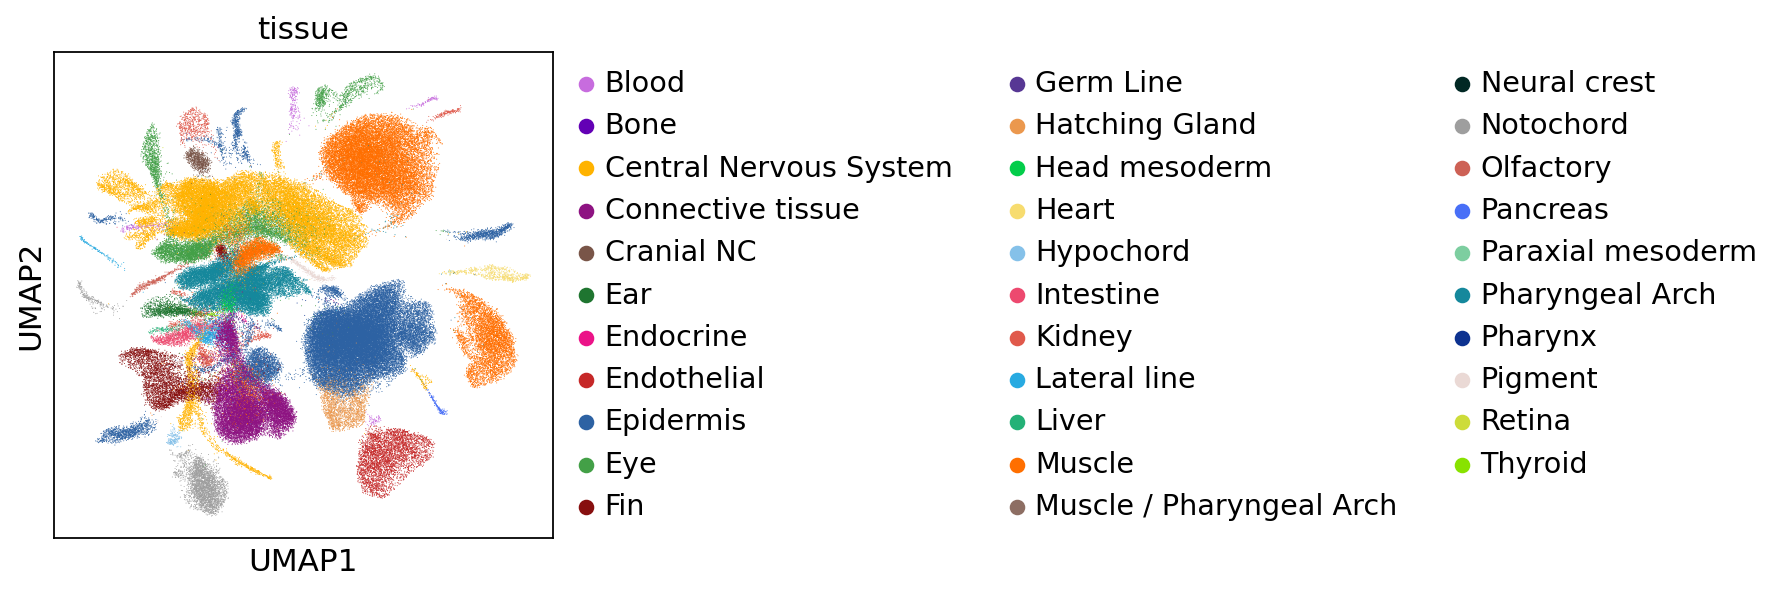

In [752]:
fig = sc.pl.umap(cdata, color="tissue", palette=color_dict, return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_control_tissues.png"))

## load again

In [483]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/zebrafish/depletion_analysis"
fig_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/zebrafish/depletion_analysis"

In [484]:
def compute_depletion(adata, num_shuffles = 1000, significance_threshold=5.0):
    binary_adj = adata.obsp['distances'] > 0
    is_perturbed = adata.obs["numerical_mode"].values
    neighbors_perturbed = binary_adj @ is_perturbed 

    rng = np.random.default_rng(0)
    null = []
    for i in range(1000):
        rng.shuffle(is_perturbed)
        null.append(binary_adj @ is_perturbed)
        
    null_vals = np.vstack(null)
    
    percentiles = []
    for i in range(len(neighbors_perturbed)):
        percentiles.append(percentileofscore(null_vals[:,i], neighbors_perturbed[i], kind='rank'))

    adata.obs["percentiles"] = percentiles
    adata.obs["is_significantly_depleted"] = adata.obs.apply(lambda x: "True" if x["percentiles"]<significance_threshold else "False", axis=1)


In [8]:
adata_pred=sc.read_h5ad(f"/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/depletion_analysis/{wandb_name}_36_preds_50k.h5ad")
adata_pred.obs["timepoint"] = adata_pred.obs.apply(lambda x: x["condition"].split("_")[-1], axis=1)
adata_pred.obs["gene_target"] = adata_pred.obs['condition'].str.split('_').str[:2].str.join('_')
adata_pred.obs["mode"] = "pred"
adata_pred.obs["gene_target"].value_counts()

In [10]:
adata_true = adata[adata.obs["condition"]=="cdx4_cdx1a_36"]
adata_true.obs["mode"] = "true"
adata_true.obs["timepoint"].value_counts()


In [17]:
control_key = "is_control"
adata_ctrl = adata[adata.obs[control_key].to_numpy()]
adata_ctrl_36 = adata_ctrl[adata_ctrl.obs["timepoint"]==36]
adata_ctrl_36.obs["mode"] = "control"
covariate_data = adata[adata.obs["gene_target"]==gene_target].obs.drop_duplicates(subset=["condition"])
covariate_data_36 = covariate_data[covariate_data["timepoint"]==36]

In [20]:
bdata = ad.concat((adata_true, adata_pred, adata_ctrl_36))

In [21]:
bdata.obs = bdata.obs.reset_index()

In [22]:
bdata.obs["timepoint"].value_counts()

timepoint
36.0    184343
36      100000
Name: count, dtype: int64

In [29]:
from cfp.preprocessing import transfer_labels, compute_wknn
compute_wknn(ref_adata=adata, query_adata=bdata, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=bdata, ref_adata=adata, label_key="cell_type_broad")
        

# Neural progenitors

In [693]:
cell_types_selection = ["neural progenitor (hindbrain)", "neural progenitor (hindbrain R7/8)", "differentiating neuron (hindbrain)", "neural progenitor (telencephalon/diencephalon)"]



In [694]:
bdata_selection = bdata[(bdata.obs["cell_type_broad_transfer"].isin(cell_types_selection))]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [695]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [696]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [697]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1656553/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1656553/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [698]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs

true      pred
differentiating neuron (hindbrain)              0.135399  0.078814
neural progenitor (hindbrain R7/8)              0.269569  0.167319
neural progenitor (hindbrain)                   0.031100  0.040670
neural progenitor (telencephalon/diencephalon)  0.090696  0.038034

In [699]:
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_neuron_progenitors.csv"))

In [700]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
differentiating neuron (hindbrain)              1.028155  0.970510
neural progenitor (hindbrain R7/8)              2.046979  2.060343
neural progenitor (hindbrain)                   0.236162  0.500803
neural progenitor (telencephalon/diencephalon)  0.688704  0.468345

In [701]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl)

In [702]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]

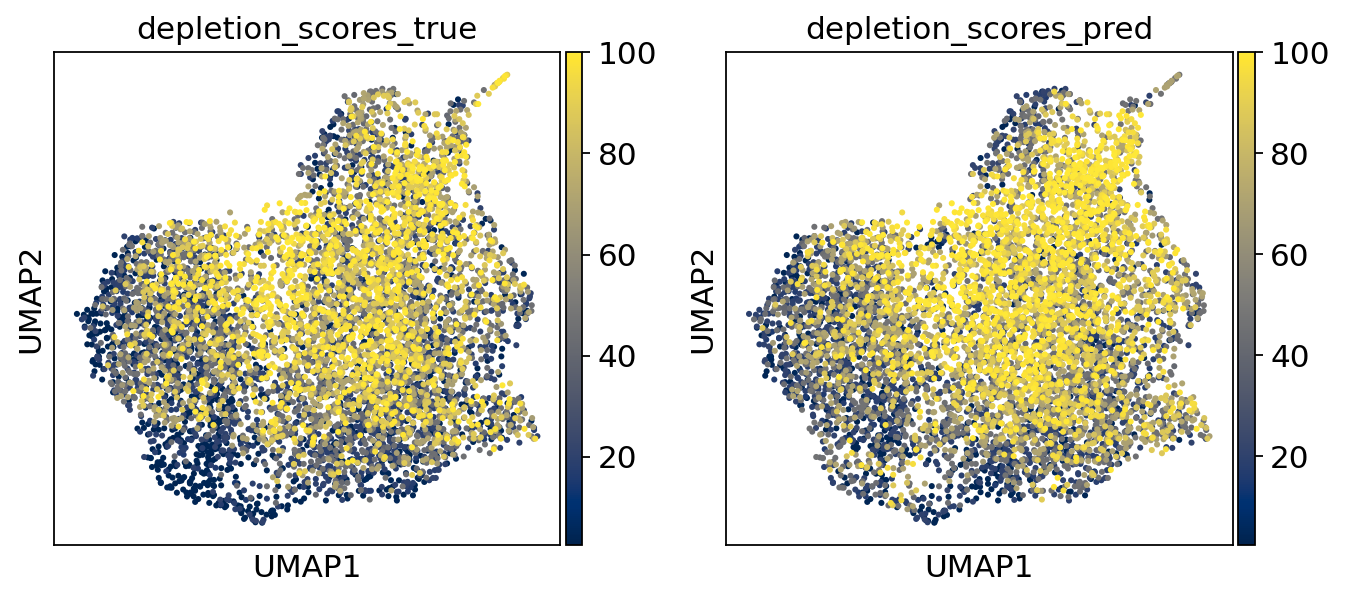

In [703]:
fig = sc.pl.umap(
    bdata_selection_ctrl, 
    s=30,
    color=["depletion_scores_true", "depletion_scores_pred"], 
    cmap="cividis",  
    return_fig=True
)

fig.savefig(os.path.join(fig_dir, "umap_depletion_neuronal_progs.png"))


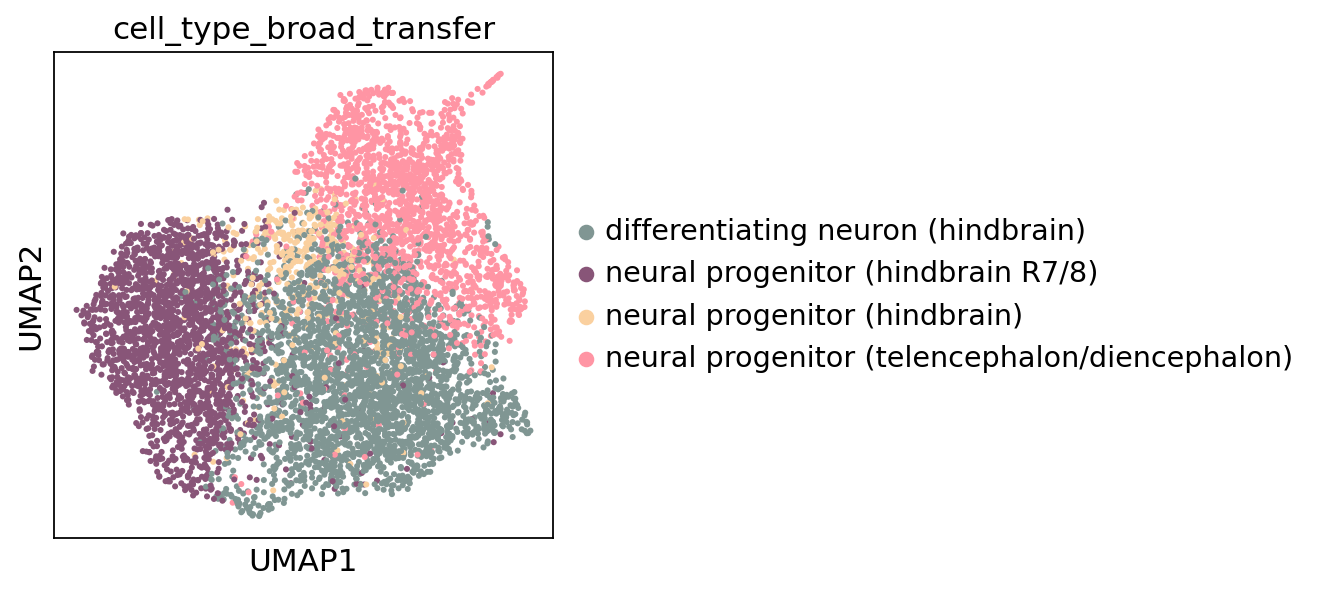

In [704]:
color_dict = {'neural progenitor (hindbrain)': "#FAD09F", 
             'neural progenitor (hindbrain R7/8)': "#885578",
             'differentiating neuron (hindbrain)': "#809693",
             'neural progenitor (telencephalon/diencephalon)': "#FF95A4"}

fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, s=30, palette=color_dict)
fig.savefig(os.path.join(fig_dir, "umap_depletion_brain_cell_types.png"))

In [705]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.464808
depletion_scores_pred               0.464808               1.000000

# Whole embryo

In [754]:
bdata_selection = bdata.copy()
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [755]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [756]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [757]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1656553/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1656553/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [758]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs

true      pred
KA neuron                   0.019841  0.015873
adrenal gland               0.000000  0.000000
anterior migratory muscle   0.020247  0.012373
basal cell                  0.009636  0.006683
cardiomyocyte               0.006279  0.009419
...                              ...       ...
support cells/otic vesicle  0.004792  0.003994
thyroid follicle cell       0.016807  0.000000
unknown (dcn+, col6+)       0.052239  0.029851
vascular smooth muscle      0.000000  0.000000
xanthophore                 0.012063  0.010856

[96 rows x 2 columns]

In [759]:
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_full_embryo.csv"))

In [760]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
KA neuron                   1.595209  1.674941
adrenal gland               0.000000  0.000000
anterior migratory muscle   1.627867  1.305662
basal cell                  0.774745  0.705225
cardiomyocyte               0.504857  0.993921
...                              ...       ...
support cells/otic vesicle  0.385297  0.421411
thyroid follicle cell       1.351236  0.000000
unknown (dcn+, col6+)       4.199924  3.149889
vascular smooth muscle      0.000000  0.000000
xanthophore                 0.969826  1.145587

[96 rows x 2 columns]

In [761]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [762]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


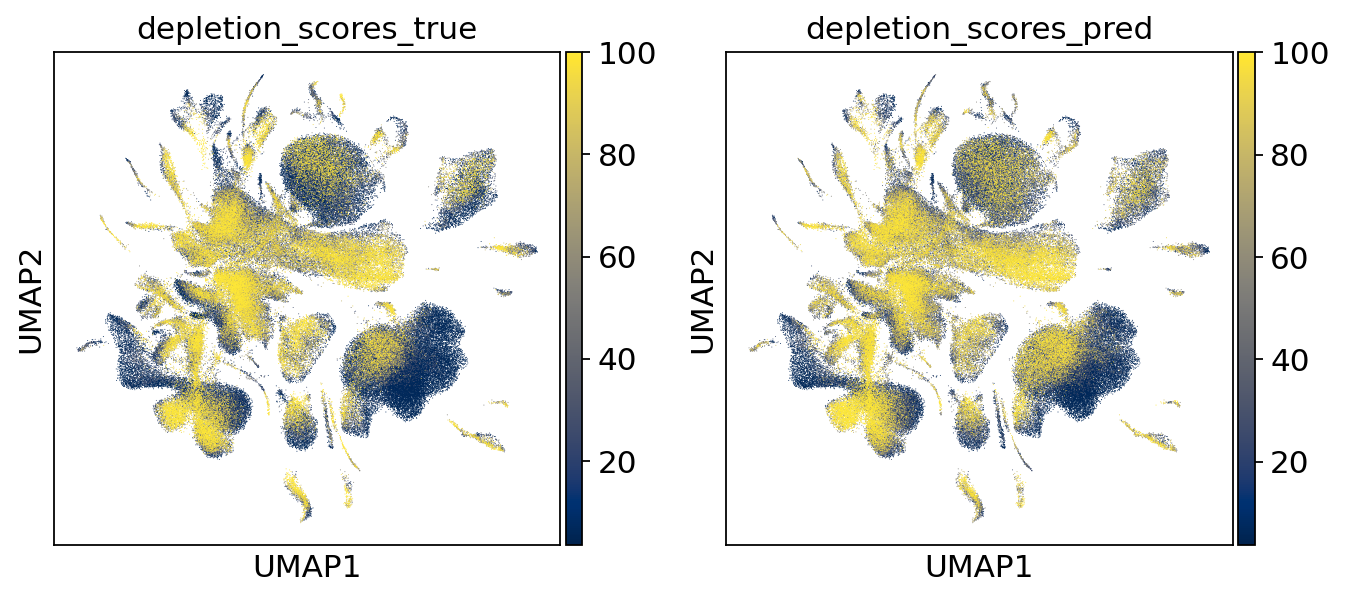

In [763]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_whole_embryo.png"))

In [764]:
cdata.obs = bdata_selection_ctrl.obs.copy()

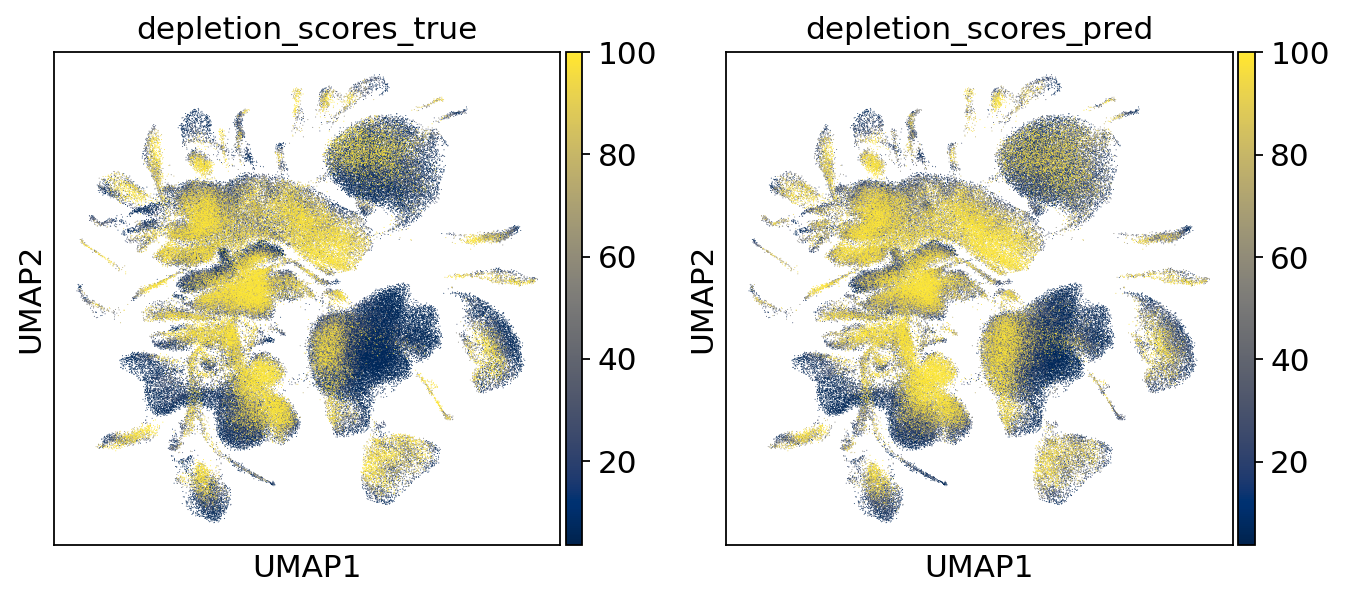

In [765]:
fig = sc.pl.umap(cdata, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_whole_embryo_same_umap.png"))

In [766]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.651168
depletion_scores_pred               0.651168               1.000000

# Fin

In [719]:
cts_to_keep = list(adata[adata.obs["tissue"].isin(("Connective tissue", "Fin"))].obs["cell_type_broad"].unique())

In [720]:
cts_to_keep 

['basal cell',
 'connective tissue-meninges-dermal FB',
 'pectoral fin bud (osteoblast+)',
 'fin fold',
 'head/eye connective tissue',
 'fin bud mesoderm (pectoral)',
 'fin mesenchyme',
 'neural tube-like connective tissue (+ taste bud)',
 'contains head vasculature?']

In [721]:
bdata_selection = bdata[bdata.obs["cell_type_broad_transfer"].isin(cts_to_keep)]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [722]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [723]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [724]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1656553/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1656553/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [725]:
df_depletion_fracs = pd.DataFrame.from_dict(df_depletion_frac_true, columns=["true"], orient="index")
df_depletion_fracs["pred"] = pd.DataFrame.from_dict(df_depletion_frac_pred, columns=["pred"], orient="index")["pred"]
df_depletion_fracs.to_csv(os.path.join(output_dir, "depletion_fracs_fin.csv"))
df_depletion_fracs

true      pred
basal cell                                        0.070873  0.073049
connective tissue-meninges-dermal FB              0.379756  0.277073
contains head vasculature?                        0.035088  0.052632
fin bud mesoderm (pectoral)                       0.543605  0.142442
fin fold                                          0.516553  0.478596
fin mesenchyme                                    0.132353  0.029412
head/eye connective tissue                        0.051707  0.016585
neural tube-like connective tissue (+ taste bud)  0.043839  0.019550
pectoral fin bud (osteoblast+)                    0.468223  0.281453

In [726]:
df_depl_normalized = df_depletion_fracs/df_depletion_fracs.mean(axis=0)
df_depl_normalized

true      pred
basal cell                                        0.284506  0.479610
connective tissue-meninges-dermal FB              1.524447  1.819138
contains head vasculature?                        0.140852  0.345555
fin bud mesoderm (pectoral)                       2.182181  0.935209
fin fold                                          2.073586  3.142245
fin mesenchyme                                    0.531302  0.193104
head/eye connective tissue                        0.207568  0.108892
neural tube-like connective tissue (+ taste bud)  0.175981  0.128355
pectoral fin bud (osteoblast+)                    1.879578  1.847892

In [727]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [728]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


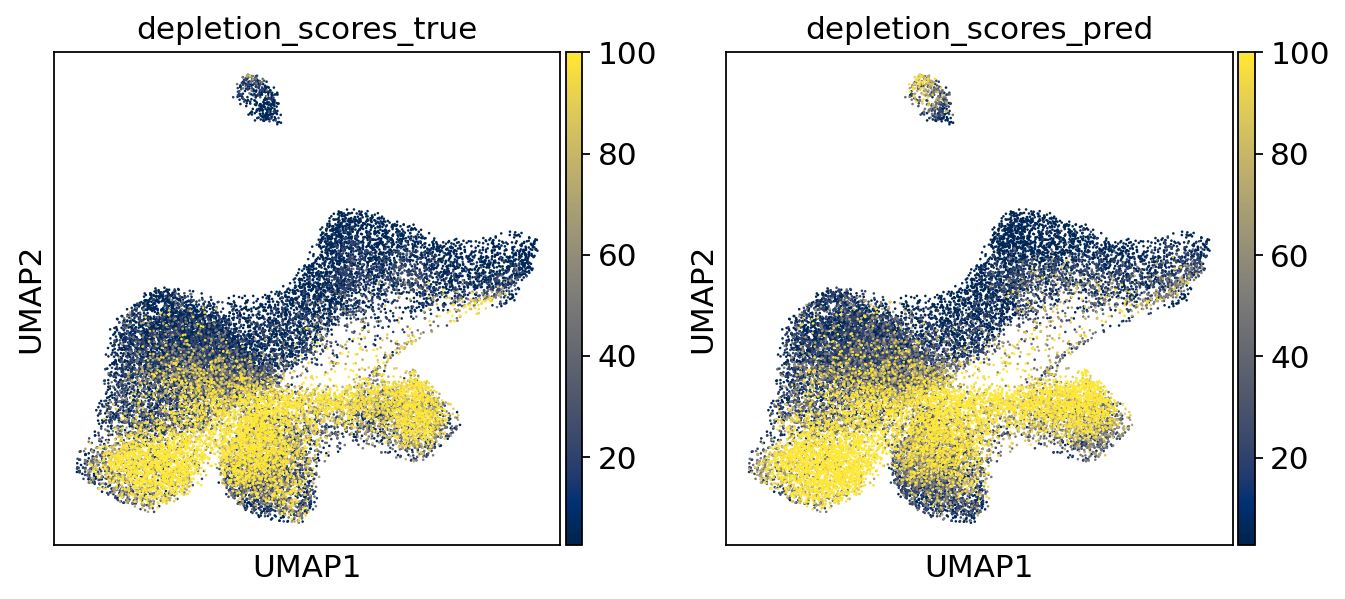

In [729]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_fin.png"))

In [730]:
colors = ["#15889C", "#ED496F", "#8E1382", "#FFB300", "#FF6F00", "#43A047", "#C62828", "#2d62a3", "#1F7530", "#573794", "#28AAE1", "#870f0f", "#9e9e9e", "#795548", "#CD6155", "#F7DC6F", "#7DCEA0", "#85C1E9", "#EB984E", "#ead9d5", "#03cd4A", "#CDDC39", "#e0594b", "#c76cde", "#24B177", "#8D6E63", "#486ff7", "#6300b5", "#88e200", "#012824", "#0d3290", "#a347fb", "#54fc7a", "#eb1388", "#b0978d", "#fe52cf", "#83f1f6", "#f1f847", "#2b1dfc", "#6c6f15", "#6ca05c", "#7788cd", "#f502f3", "#0dc290", "#fa0e03", "#3caa0a", "#befc8d", "#08f8eb", "#b1cd3f", "#d6a5fa", "#ce606c", "#ab1eba", "#6ecc9f", "#054ddc", "#486ff7", "#854f49", "#f22B21", "#3a0e43", "#225805", "#37d160", "#e4b974", "#a8bade", "#47edd1", "#f47a92", "#c76cde", "#9106eb", "#81aa20", "#d7fdfd", "#5deb2e", "#f82745", "#6435e0", "#027ffe", "#8e3101", "#16f648", "#1c15bc", "#8be46e", "#8d6fa0", "#e68fc6", "#058ca9", "#9e018a", "#bdfd0b", "#b22760", "#2bf49f", "#cb9348", "#9d8303", "#c251a1", "#46adaf", "#a3e3af", "#22bb34", "#6ea3fa", "#260374", "#1c3854", "#405d37", "#c21df3", "#fcea92", "#537f88", "#fd4c18", "#f2d71e", "#fd4c7a"]
cts = list(bdata_selection_ctrl.obs["cell_type_broad_transfer"].unique())
color_dict_fin = {t: colors[-(i-4)] for i,t in enumerate(cts)}

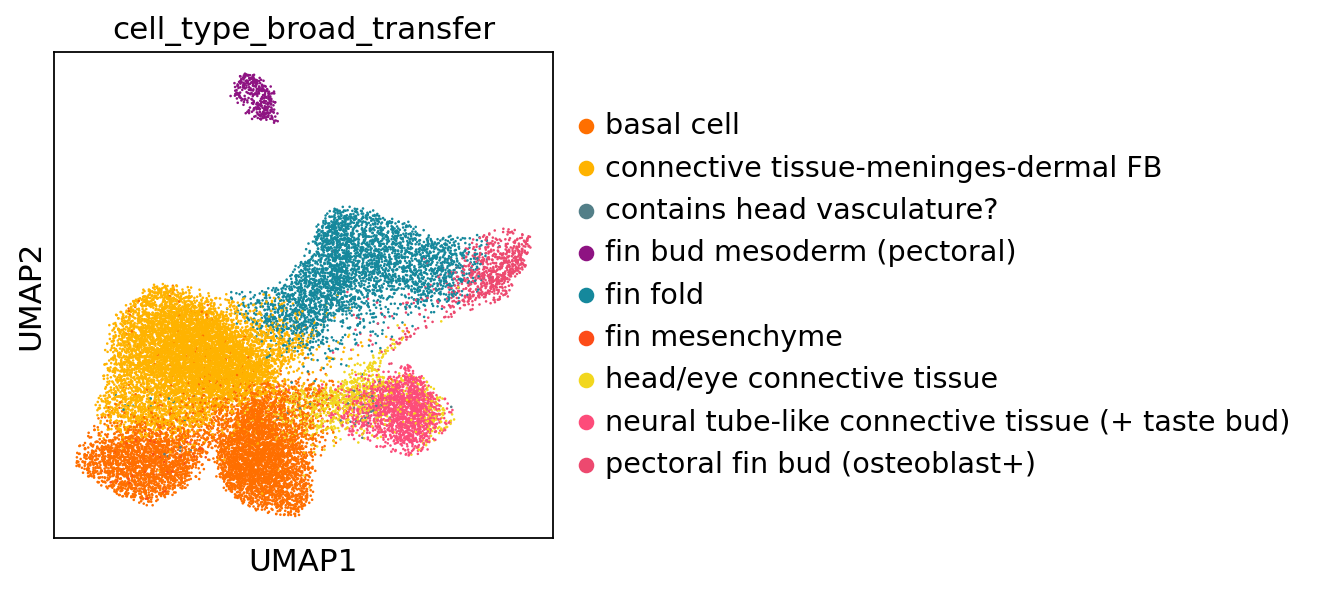

In [731]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, palette=color_dict_fin)
fig.savefig(os.path.join(fig_dir, "umap_depletion_fin_cell_types.png"))

In [732]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.720355
depletion_scores_pred               0.720355               1.000000

In [733]:
color_dict_fin

{'basal cell': '#FF6F00',
 'connective tissue-meninges-dermal FB': '#FFB300',
 'fin bud mesoderm (pectoral)': '#8E1382',
 'pectoral fin bud (osteoblast+)': '#ED496F',
 'fin fold': '#15889C',
 'neural tube-like connective tissue (+ taste bud)': '#fd4c7a',
 'head/eye connective tissue': '#f2d71e',
 'fin mesenchyme': '#fd4c18',
 'contains head vasculature?': '#537f88'}

# Muscle cell

In [734]:
muscle_cts = list(adata[adata.obs["tissue"]=="Muscle"].obs["cell_type_broad"].unique())
bdata_selection = bdata[bdata.obs["cell_type_broad_transfer"].isin(muscle_cts)]
bdata_selection.obs = bdata_selection.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [735]:

bdata_selection.obs["mode"] = bdata_selection.obs["mode"].astype(str)

# Get minimum sample count for downsampling
downsample_to = bdata_selection.obs["mode"].value_counts().reindex(["pred", "true"], fill_value=0).min()

# Proper indexing for AnnData (use boolean mask on .obs index)
bdata_selection_ctrl = bdata_selection[bdata_selection.obs["mode"] == "control"].copy()
bdata_selection_true = bdata_selection[bdata_selection.obs["mode"] == "true"].copy()
bdata_selection_pred = bdata_selection[bdata_selection.obs["mode"] == "pred"].copy()

# Subsample only if necessary
if bdata_selection_pred.n_obs > downsample_to:
    bdata_selection_pred = sc.pp.subsample(bdata_selection_pred, n_obs=downsample_to, copy=True)

if bdata_selection_true.n_obs > downsample_to:
    bdata_selection_true = sc.pp.subsample(bdata_selection_true, n_obs=downsample_to, copy=True)

bdata_selection_ctrl_true = ad.concat([bdata_selection_ctrl, bdata_selection_true])
bdata_selection_ctrl_pred = ad.concat([bdata_selection_ctrl, bdata_selection_pred])

rsc.pp.neighbors(bdata_selection_ctrl_true, use_rep="X_aligned")
rsc.pp.neighbors(bdata_selection_ctrl_pred, use_rep="X_aligned")

rsc.tl.umap(bdata_selection_ctrl_true)
rsc.tl.umap(bdata_selection_ctrl_pred)

bdata_selection_ctrl_true.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_true.obs["mode"] == "control", 0.0, 1.0
)
bdata_selection_ctrl_pred.obs["numerical_mode"] = np.where(
    bdata_selection_ctrl_pred.obs["mode"] == "control", 0.0, 1.0
)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [736]:
compute_depletion(bdata_selection_ctrl_pred)
compute_depletion(bdata_selection_ctrl_true)
bdata_selection_ctrl_pred.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_pred.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)
bdata_selection_ctrl_true.obs["is_significantly_depleted_and_control"] = bdata_selection_ctrl_true.obs.apply(lambda x: "True" if (x["is_significantly_depleted"]=="True" and x["mode"]=="control") else "False", axis=1)

In [737]:
df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_pred = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_pred[ct] = frac_depleted.values



df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
df_depletion = df_depletion.reset_index()
df_depletion_frac_true = {}
for ct in df_depletion["cell_type_broad_transfer"].unique():
    df = df_depletion[df_depletion["cell_type_broad_transfer"]==ct]
    frac_depleted = df[df["is_significantly_depleted"] == "True"]["count"] / df["count"].sum()
    df_depletion_frac_true[ct] = frac_depleted.values


/tmp/ipykernel_1656553/1086478450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_pred[bdata_selection_ctrl_pred.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_significantly_depleted"]).value_counts().to_frame()
/tmp/ipykernel_1656553/1086478450.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_depletion = bdata_selection_ctrl_true[bdata_selection_ctrl_true.obs["mode"]=="control"].obs[["cell_type_broad_transfer", "is_significantly_depleted"]].groupby(["cell_type_broad_transfer", "is_s

In [738]:
rsc.pp.neighbors(bdata_selection_ctrl, use_rep="X_aligned")
rsc.tl.umap(bdata_selection_ctrl, min_dist=0.9)

In [739]:
bdata_selection_ctrl.obs["depletion_true"] = bdata_selection_ctrl_true.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_pred"] = bdata_selection_ctrl_pred.obs["is_significantly_depleted"]
bdata_selection_ctrl.obs["depletion_scores_true"] = bdata_selection_ctrl_true.obs["percentiles"]
bdata_selection_ctrl.obs["depletion_scores_pred"] = bdata_selection_ctrl_pred.obs["percentiles"]


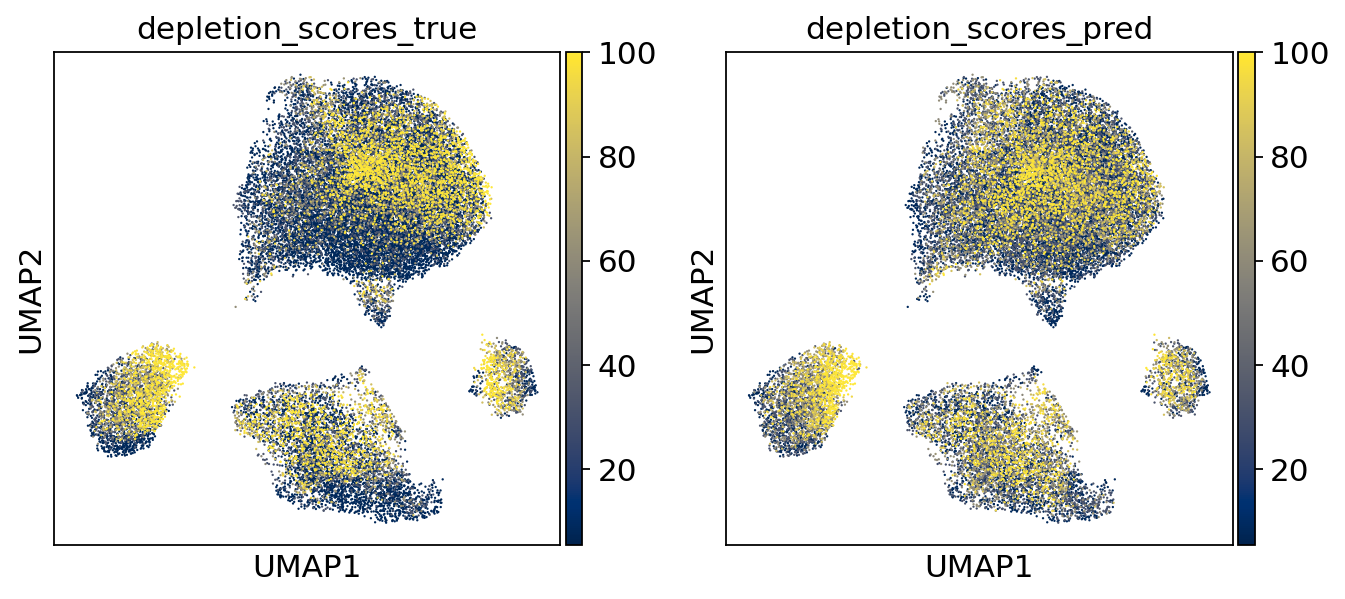

In [740]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["depletion_scores_true", "depletion_scores_pred"], cmap="cividis", return_fig=True)
fig.savefig(os.path.join(fig_dir, "umap_depletion_muscle_cell.png"))

In [741]:
colors = ["#15889C", "#ED496F", "#8E1382", "#FFB300", "#FF6F00", "#43A047", "#C62828", "#2d62a3", "#1F7530", "#573794", "#28AAE1", "#870f0f", "#9e9e9e", "#795548", "#CD6155", "#F7DC6F", "#7DCEA0", "#85C1E9", "#EB984E", "#ead9d5", "#03cd4A", "#CDDC39", "#e0594b", "#c76cde", "#24B177", "#8D6E63", "#486ff7", "#6300b5", "#88e200", "#012824", "#0d3290", "#a347fb", "#54fc7a", "#eb1388", "#b0978d", "#fe52cf", "#83f1f6", "#f1f847", "#2b1dfc", "#6c6f15", "#6ca05c", "#7788cd", "#f502f3", "#0dc290", "#fa0e03", "#3caa0a", "#befc8d", "#08f8eb", "#b1cd3f", "#d6a5fa", "#ce606c", "#ab1eba", "#6ecc9f", "#054ddc", "#486ff7", "#854f49", "#f22B21", "#3a0e43", "#225805", "#37d160", "#e4b974", "#a8bade", "#47edd1", "#f47a92", "#c76cde", "#9106eb", "#81aa20", "#d7fdfd", "#5deb2e", "#f82745", "#6435e0", "#027ffe", "#8e3101", "#16f648", "#1c15bc", "#8be46e", "#8d6fa0", "#e68fc6", "#058ca9", "#9e018a", "#bdfd0b", "#b22760", "#2bf49f", "#cb9348", "#9d8303", "#c251a1", "#46adaf", "#a3e3af", "#22bb34", "#6ea3fa", "#260374", "#1c3854", "#405d37", "#c21df3", "#fcea92", "#537f88", "#fd4c18", "#f2d71e", "#fd4c7a"]
cts = list(bdata_selection_ctrl.obs["cell_type_broad_transfer"].unique())
color_dict_muscle = {t: colors[-(i-14)] for i,t in enumerate(cts)}

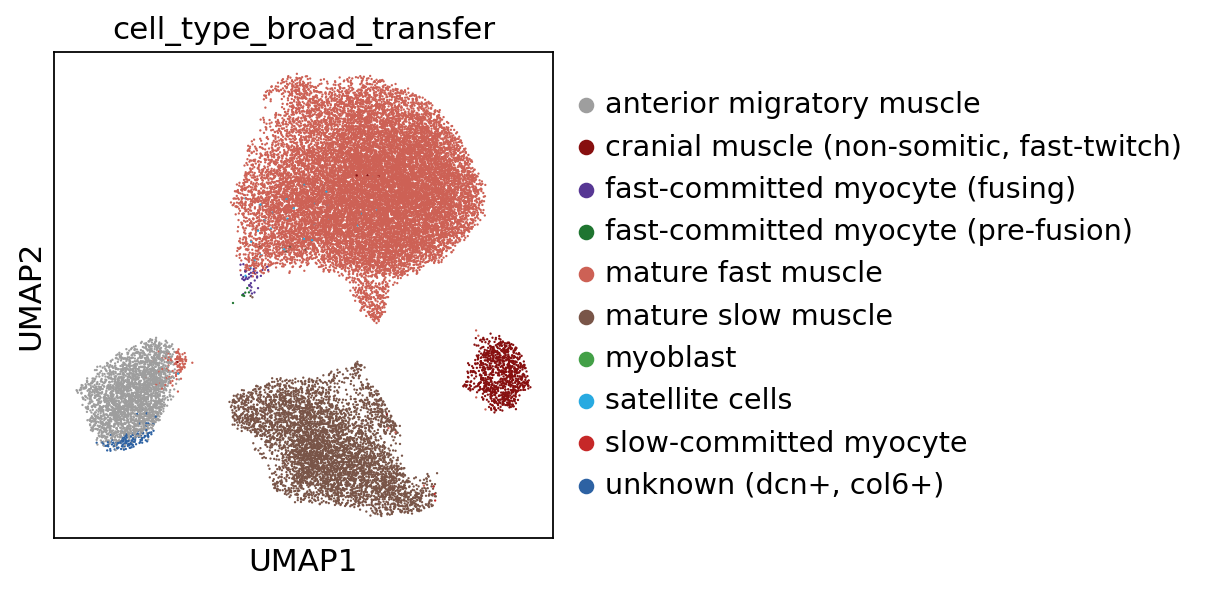

In [742]:
fig = sc.pl.umap(bdata_selection_ctrl, color=["cell_type_broad_transfer"], return_fig=True, palette=color_dict_muscle)
fig.savefig(os.path.join(fig_dir, "umap_depletion_muscle_cell_types.png"))

In [743]:
bdata_selection_ctrl.obs[["depletion_scores_true", "depletion_scores_pred"]].corr()

depletion_scores_true  depletion_scores_pred
depletion_scores_true               1.000000               0.604649
depletion_scores_pred               0.604649               1.000000